In [62]:
import kagglehub as kg
path = kg.dataset_download("khsamaha/aviation-accident-database-synopses")

In [63]:
encoding = 'Windows-1252'
with open(path + '/AviationData.csv', 'r', encoding=encoding) as f:
    data = f.read()

with open('AviationData_utf8.csv', 'w', encoding='utf-8') as f:
    f.write(data)

In [64]:
import pandas as pd
df = pd.read_csv('AviationData_utf8.csv', low_memory=False)

In [5]:
import numpy as np
import re
import matplotlib.pyplot as plt

%matplotlib inline

## EDA and Data Cleaning
First, I want to get a sense of the dataset itself and what transformations and cleaning may need to be done to get it in a workable format. 

From looking at the columns of the dataset, certain columns have a relatively large proportion of null values (e.g., latitutde and longitude; airport name; and air carrier).

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      88889 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50249 non-null  object 
 9   Airport.Name            52790 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87572 non-null  object 
 14  Make                    88826 non-null

Again, given that we are interested in commercial aviation use, let's narrow our focus to airplanes only.

In [66]:
df = df[df['Aircraft.Category'].isin(['Airplane'])].reset_index()

### Dropping Unhelpful Columns
I'm choosing to drop columns which are of limited use for my purposes here, e.g. those with redundant info (lat./long. when I already have location) and report status (string-based narrative data).

In [68]:
df.drop(['index','Latitude','Longitude','Investigation.Type',
         'Publication.Date','FAR.Description'],axis=1,inplace=True)

### Event Date
Event.Date column is not in datetime format, I'll correct this.

In [70]:
type(df['Event.Date'][1])

str

In [71]:
df['Event.Date'] = pd.to_datetime(df['Event.Date'])

In [72]:
type(df['Event.Date'][1])

pandas._libs.tslibs.timestamps.Timestamp

### Air Carrier
Of the air carrier values with non-null entries , it seems that the values are a mix of established carriers (e.g., American, United) which are likely to be helpful in my analysis and other values (e.g., YOUNGBLOOD LARRY J) which are likely to be less helpful when looking at commercial aviation.

In [73]:
df['Air.carrier'].value_counts()

Pilot                                  231
American Airlines                       47
United Airlines                         43
Delta Air Lines                         42
SOUTHWEST AIRLINES CO                   41
                                      ... 
J A FLIGHT SERVICES LLC                  1
Business & Pleasure Air Charter LLC      1
Richard T Gardner                        1
Facebook, Inc.                           1
HOHMANN COURTNEY P                       1
Name: Air.carrier, Length: 9592, dtype: int64

In [74]:
df['Air.carrier'].str.title().value_counts()

Pilot                            231
American Airlines                 47
Southwest Airlines Co             43
United Airlines                   43
Delta Air Lines                   42
                                ... 
Germania Fluggesellschaft Mbh      1
Walter J. Book                     1
Wallace Wayne P                    1
Riley W Kent                       1
Randy Coyne                        1
Name: Air.carrier, Length: 9332, dtype: int64

I want to eliminate as much duplication of air carriers that results from case sensitivity.

In [75]:
df['Air.carrier'] = df['Air.carrier'].str.title()

### Aircraft Make and Model
I see that Aircraft Make is likely to be a problem. For example, "Cessna" and "CESSNA" both appear here -- I will standardize the cases.

In [76]:
df.value_counts('Make')

Make
CESSNA                4867
Cessna                3608
PIPER                 2805
Piper                 1910
BOEING                1037
                      ... 
Merit Aviation Llc       1
Menefee                  1
Mendenhall               1
Mellema                  1
177MF LLC                1
Length: 3874, dtype: int64

In [77]:
df['Make'].str.title().value_counts()

Cessna                     8475
Piper                      4715
Beech                      1692
Boeing                     1324
Mooney                      419
                           ... 
Woods Rufus Iii               1
Blevins Kamron                1
Experimental Amat Built       1
Schaffer                      1
Karpayev Vladyslav V          1
Name: Make, Length: 3537, dtype: int64

By converting all strings in the Make column to the same case, 337 erroneously separated values were consolidated and the count of "Cessna" increased by ~74%. I'll permanently convert this column to title case and check if the same issue exists in the Model column.

In [78]:
df['Make'] = df['Make'].str.title()

In [79]:
df['Model'].value_counts()

172                 870
152                 451
737                 404
182                 345
172N                316
                   ... 
TB 21-TC              1
PIPER PA-28-140       1
707-323C              1
GLASAIR III T         1
TB10 - NO SERIES      1
Name: Model, Length: 5367, dtype: int64

In [80]:
df['Model'].str.title().value_counts()

172                 870
152                 451
737                 404
182                 345
172N                316
                   ... 
Pa-28-R200            1
550B                  1
Wag Aero Sport        1
Ch701Sp               1
Wittman Tailwind      1
Name: Model, Length: 5080, dtype: int64

Converting cases wasn't as impactful for the Model column, likely because Model values are more likely to be numeric in nature. Nonetheless, it decreased the number of unique values by ~5%, so I'll convert to title case.

In [81]:
df['Model'] = df['Model'].str.title()

### Location
I'll standardize the case for location as well.

In [82]:
df['Location'] = df['Location'].str.title()

### Amateur vs Commercial Aircraft
This analysis should only focus on commercial aviation, so I'll exclude any amateur-built aircraft.

In [83]:
df.value_counts('Amateur.Built')

Amateur.Built
No     24417
Yes     3183
dtype: int64

In [85]:
df = df[df['Amateur.Built'] == 'No'].reset_index().drop(['index'], axis=1)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24417 entries, 0 to 24416
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Event.Id                24417 non-null  object        
 1   Accident.Number         24417 non-null  object        
 2   Event.Date              24417 non-null  datetime64[ns]
 3   Location                24411 non-null  object        
 4   Country                 24410 non-null  object        
 5   Airport.Code            15574 non-null  object        
 6   Airport.Name            16012 non-null  object        
 7   Injury.Severity         23604 non-null  object        
 8   Aircraft.damage         23147 non-null  object        
 9   Aircraft.Category       24417 non-null  object        
 10  Registration.Number     24214 non-null  object        
 11  Make                    24414 non-null  object        
 12  Model                   24399 non-null  object

### Registration Numbers with Multiple Incidents

In [87]:
(len(df['Registration.Number'])-len(df['Registration.Number'].unique()))/len(df['Registration.Number'])

0.04406765777941598

Around 4% of aircraft in the dataframe have had more than one incident recorded. It could be interesting to see what, if anything, is happening differently with those aircraft.

In [39]:
multi_incident_aircraft = [x for x in df['Registration.Number'].unique() if df['Registration.Number'].value_counts().get(x,0) >1]

In [89]:
multi_incident_df = df[df['Registration.Number'].isin(multi_incident_aircraft)]

In [92]:
multi_incident_df.describe()

,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
count,1532.000000,1420.000000,1431.000000,1441.000000,1654.000000
mean,1.127285,0.249296,0.248777,0.181818,8.514510
std,0.374026,3.048093,1.723437,0.980492,35.073781
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,0.000000,2.000000
max,4.000000,112.000000,53.000000,27.000000,380.000000


### Concluding EDA
After going through some initial exploration and cleaning of the data, we are down to 24417 entires. These reflect a population of incidents which are more useful for understanding safely operating a commercial aviation enterprise.

## Initial Thoughts
From looking at the columns, there are a lot of columns with relatively high null values.  For example, Air.carrier

Which aircraft saw the biggest drops in fatalities over the years? <br>
Did any aircraft see an increase in fatalities over the years? <br>

### Visualizations:
Total crashes over time <br>
Geographic plot of crashes



### High-Level Summary Statistics

In [42]:
df['Event.Date'].value_counts().sort_index(ascending=True).index.year

Int64Index([1979, 1982, 1982, 1982, 1982, 1982, 1982, 1982, 1982, 1982,
            ...
            2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022],
           dtype='int64', length=7380)

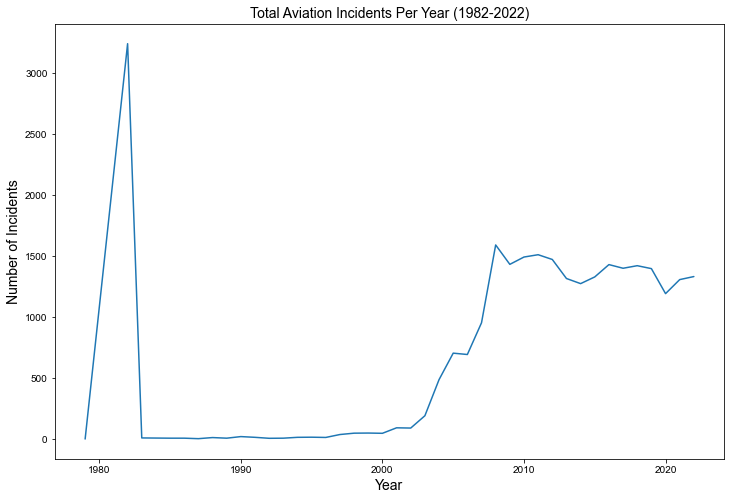

In [31]:
# Total Incidents Per Year
dates = df['Event.Date'].value_counts().sort_index(ascending=True)

# Dropping some index values for years with very low counts to make the plot more legible
#dates_to_drop = pd.to_datetime(['1948-10-24', '1962-07-19','1974-08-30', '1977-06-19', '1979-08-02', '1979-09-17','1981-08-01',])
#dates.drop(index=dates_to_drop,inplace=True)

import seaborn as sns

fig,ax=plt.subplots(figsize=(12,8))

counts = dates.groupby(dates.index.year).sum()
years = counts.index

sns.set_style('darkgrid')

ax.plot(years,counts)
ax.set_title('Total Aviation Incidents Per Year (1982-2022)', fontsize=14)
ax.set_ylabel('Number of Incidents', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
plt.show()